In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
import sys
import os
sys.path.append(os.path.join('..', '..', '..' ))

from shared.cifar10_dvs_dataset import CIFAR10DVSData

data_handler = CIFAR10DVSData(save_to='../../../shared/datasets')
data_handler.check_and_download()

train_dataloader, val_dataloader, test_dataloader = data_handler.get_frame_dataloader(batch_size=128, train_ratio=0.7)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIFAR10DVS Data handler initialized. Data will be saved to '../../../shared/datasets'
Download check complete.
Splited dataset into:
 - Training set: 7000 samples
 - Validation set: 1500 samples
 - Test set: 1500 samples


Shape of a frame-based data batch: torch.Size([128, 1, 32, 32])
Labels of the batch: tensor([1, 2, 9, 9, 7, 4, 6, 2, 8, 4, 7, 4, 4, 0, 8, 7, 0, 3, 5, 2, 2, 4, 4, 5,
        5, 7, 7, 2, 4, 5, 6, 5, 3, 0, 5, 0, 9, 2, 2, 3, 9, 9, 4, 0, 9, 0, 7, 9,
        0, 4, 6, 1, 5, 3, 4, 4, 0, 3, 9, 0, 7, 5, 6, 0, 6, 4, 4, 0, 7, 6, 9, 9,
        8, 0, 8, 1, 1, 8, 0, 9, 8, 5, 1, 1, 5, 4, 8, 3, 5, 9, 5, 2, 8, 1, 5, 3,
        5, 3, 9, 6, 7, 4, 8, 8, 3, 2, 5, 0, 9, 4, 3, 4, 2, 8, 7, 3, 0, 7, 4, 5,
        6, 3, 1, 4, 1, 6, 6, 0])


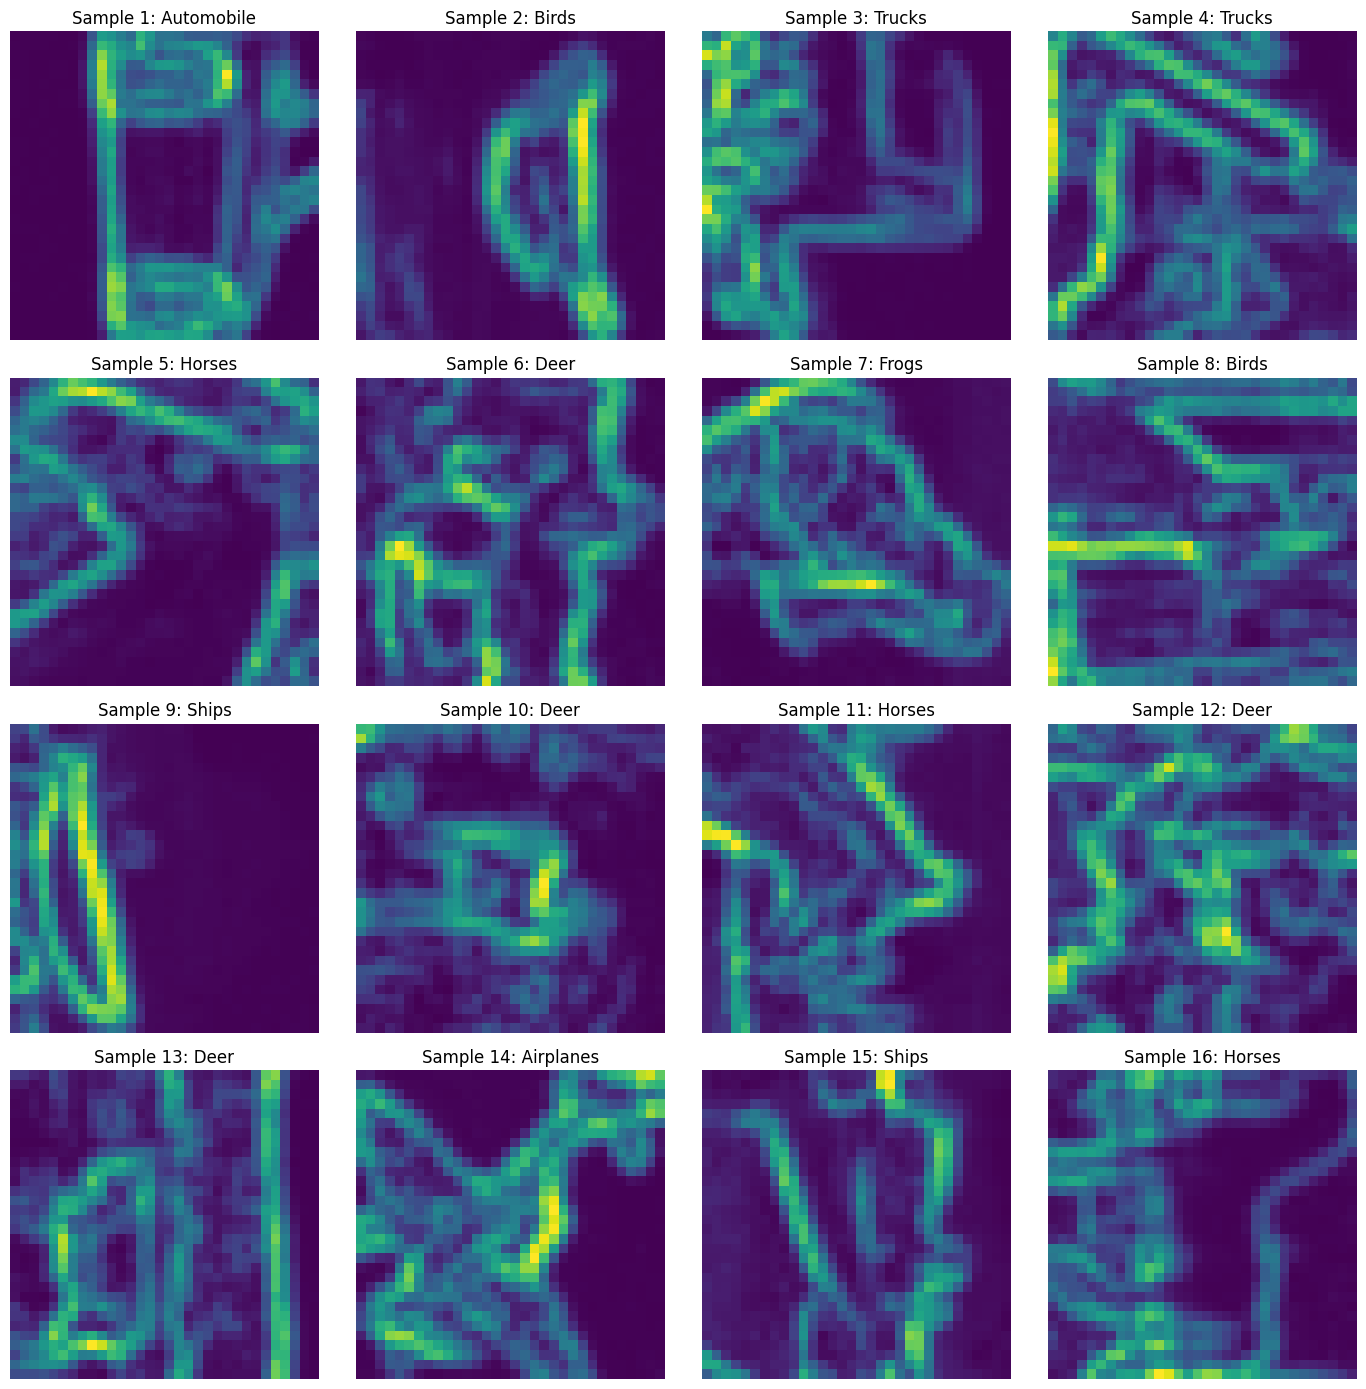

In [3]:
import matplotlib.pyplot as plt

# Get one batch from the train_dataloader
samples, labels = next(iter(train_dataloader))
print(f"Shape of a frame-based data batch: {samples.shape}")
print(f"Labels of the batch: {labels}")


batch_size = samples.shape[0]
fig, axes = plt.subplots(4, 4, figsize=(14, 14))  # For batch_size=16
axes = axes.flatten()

for i in range(16):
    sample_img = samples[i, 0]  # shape: [H, W]
    ax = axes[i]
    ax.imshow(sample_img)
    label_index = labels[i].item()
    label_name = data_handler.labels[label_index]
    ax.set_title(f"Sample {i+1}: {label_name}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn

class VGG9Model(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG9Model, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [5]:
akida_pytorch_model = VGG9Model()
akida_pytorch_model.to(device)
print(akida_pytorch_model)

VGG9Model(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [6]:
total_params = sum(p.numel() for p in akida_pytorch_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 1605578


In [7]:
from shared.early_stopping import EarlyStopping
from shared.system_monitor import SystemMonitor

monitor = SystemMonitor(sample_interval=1.0)

# Define training rules
optimizer = torch.optim.Adam(akida_pytorch_model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=3, delta=0.01)

In [9]:
from shared.pytorch_trainer import Trainer

trainer = Trainer(
    model=akida_pytorch_model,
    train_loader=train_dataloader,  
    val_loader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    early_stopping=early_stopping)

In [10]:
monitor.start()

trainer.train(num_epochs=100, log_interval=10)

monitor.stop()

System monitor started.
Starting training...
Train Epoch: 1 [1152/7000 (16%)]	Loss: 2.259397
Train Epoch: 1 [2432/7000 (35%)]	Loss: 2.145868
Train Epoch: 1 [3712/7000 (53%)]	Loss: 1.935512
Train Epoch: 1 [4992/7000 (71%)]	Loss: 2.054621
Train Epoch: 1 [6272/7000 (89%)]	Loss: 1.927056
Epoch 1 Summary -> Train Loss: 2.1102, Val Loss: 1.9267

Train Epoch: 2 [1152/7000 (16%)]	Loss: 1.999011
Train Epoch: 2 [2432/7000 (35%)]	Loss: 1.845061
Train Epoch: 2 [3712/7000 (53%)]	Loss: 1.882983
Train Epoch: 2 [4992/7000 (71%)]	Loss: 1.817019
Train Epoch: 2 [6272/7000 (89%)]	Loss: 1.709699
Epoch 2 Summary -> Train Loss: 1.8616, Val Loss: 1.7897

Train Epoch: 3 [1152/7000 (16%)]	Loss: 1.741673
Train Epoch: 3 [2432/7000 (35%)]	Loss: 1.793844
Train Epoch: 3 [3712/7000 (53%)]	Loss: 1.846314
Train Epoch: 3 [4992/7000 (71%)]	Loss: 1.715429
Train Epoch: 3 [6272/7000 (89%)]	Loss: 1.682290
Epoch 3 Summary -> Train Loss: 1.7129, Val Loss: 1.6786

Train Epoch: 4 [1152/7000 (16%)]	Loss: 1.722269
Train Epoch: 4 [

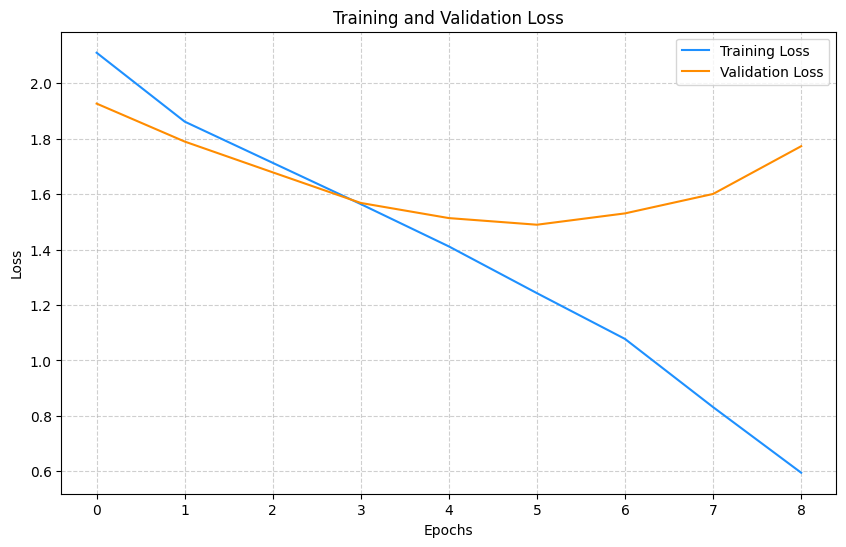

In [11]:
trainer.plot_learning_curve()


--- Test Set Evaluation ---
Average loss: 1.9466, Accuracy: 709/1500 (47.27%)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.49      0.47       140
           1       0.62      0.67      0.64       166
           2       0.36      0.31      0.33       144
           3       0.32      0.29      0.30       150
           4       0.40      0.46      0.43       146
           5       0.47      0.28      0.35       163
           6       0.45      0.57      0.50       142
           7       0.59      0.43      0.50       161
           8       0.61      0.52      0.56       138
           9       0.47      0.71      0.57       150

    accuracy                           0.47      1500
   macro avg       0.47      0.47      0.47      1500
weighted avg       0.48      0.47      0.47      1500


Confusion Matrix:


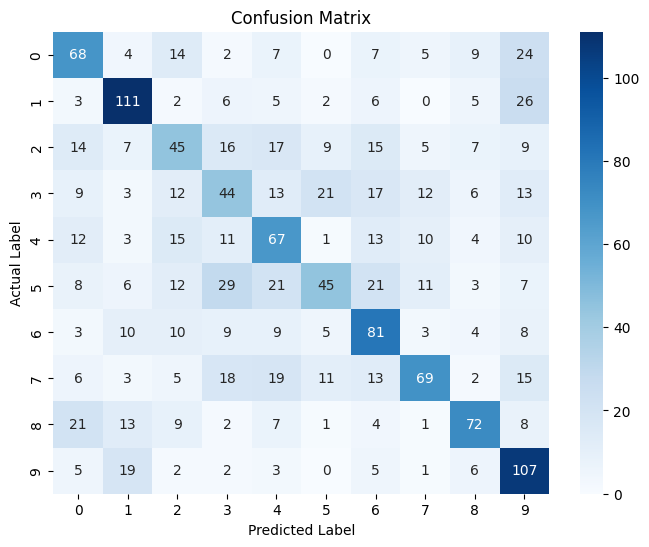

In [13]:
trainer.evaluate(test_dataloader)

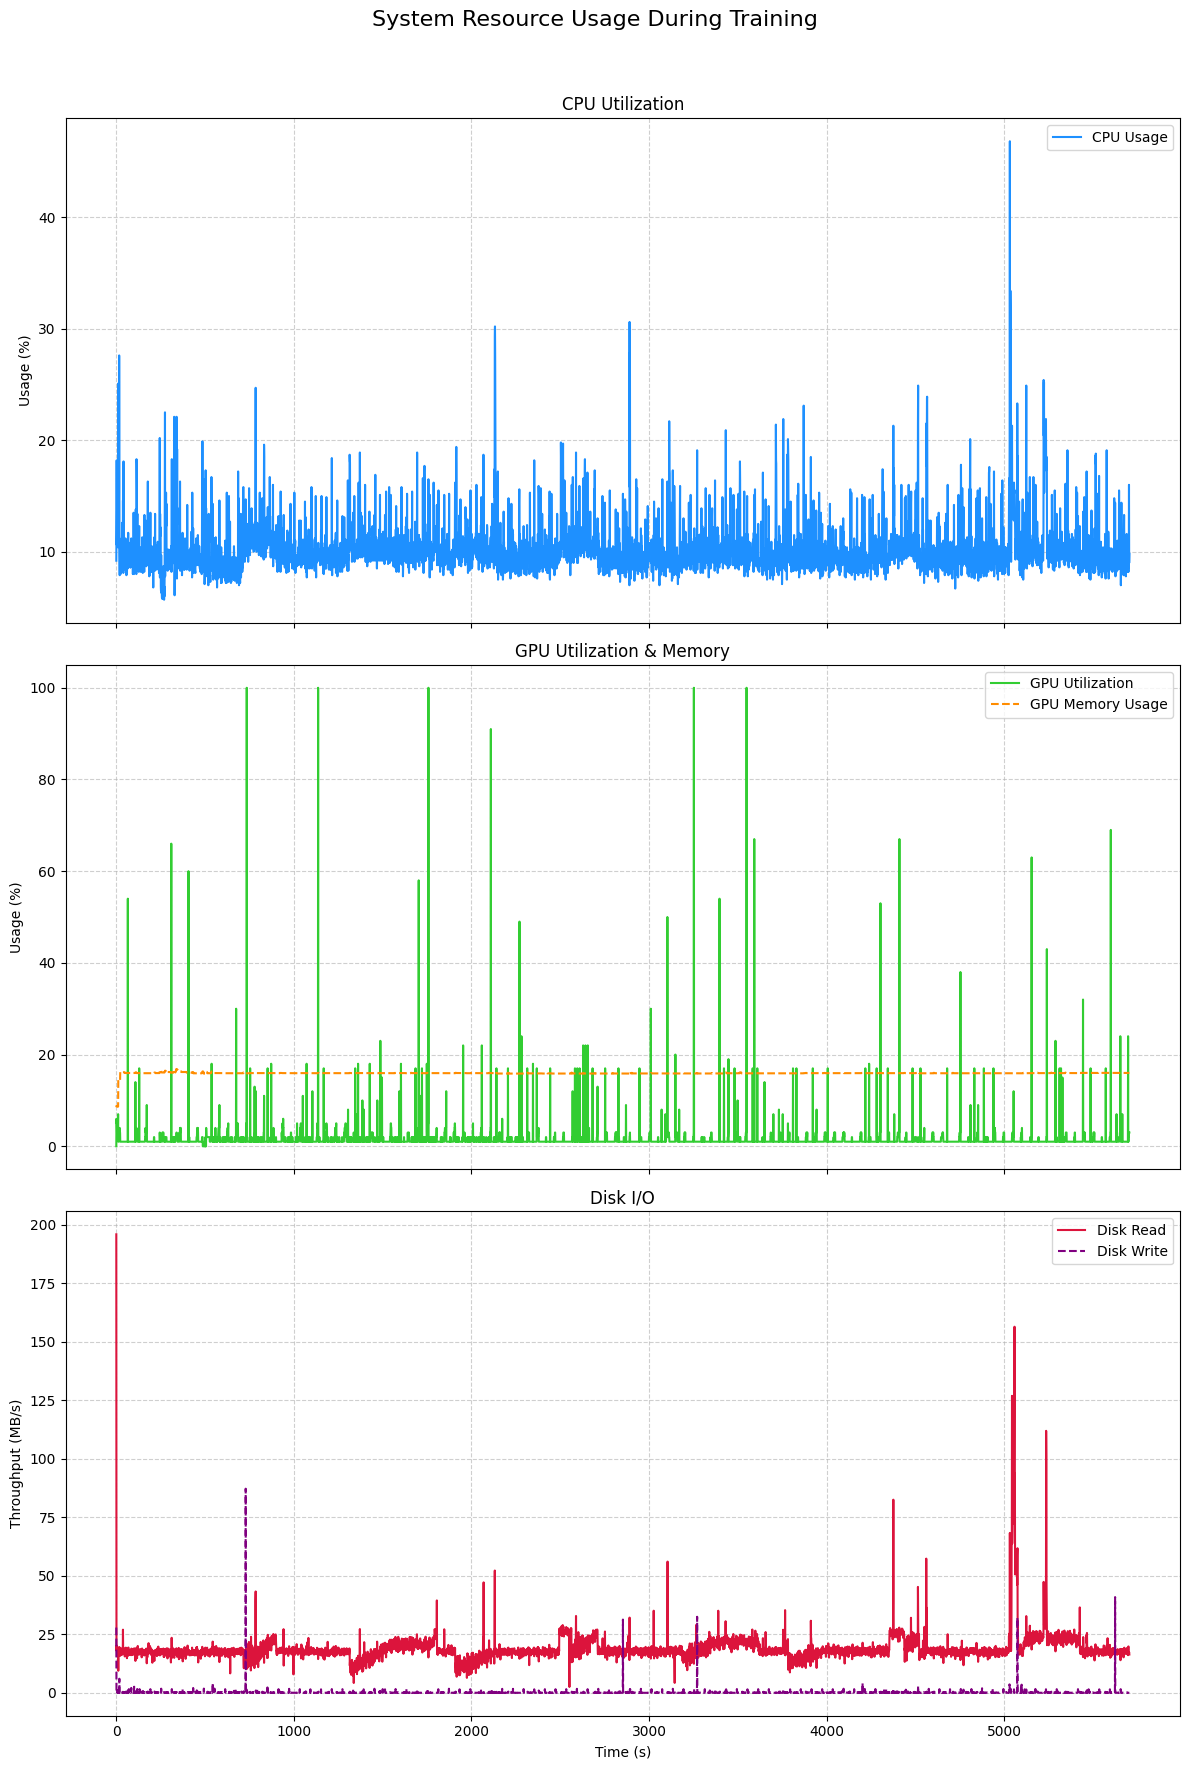

In [14]:
monitor.plot_results()

In [17]:
import onnx
sample, _ = next(iter(train_dataloader))
sample = sample.to(device)
torch.onnx.export(akida_pytorch_model,
                  sample,
                  f="pytorch_cifar10_dvs.onnx",
                  input_names=["inputs"],
                  output_names=["outputs"],
                  dynamic_axes={'inputs': {0: 'batch_size'}, 'outputs': {0: 'batch_size'}})

In [18]:
from quantizeml.models import quantize

# Read the exported ONNX model
model_onnx = onnx.load_model("pytorch_cifar10_dvs.onnx")

# Extract a batch of train samples for calibration
calib_samples = next(iter(train_dataloader))[0].numpy()

# Quantize
model_quantized = quantize(model_onnx, samples=calib_samples)
print(onnx.helper.printable_graph(model_quantized.graph))

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\onnxscript\converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Applied 3 of general pattern rewrite rules.
Calibrating with 128/128.0 samples
graph main_graph_Extracted from {main_graph} (
  %inputs[FLOAT, batch_sizex1x32x32]
) initializers (
  %quantize_scale[FLOAT, 1]
  %quantize_zp[UINT8, 1]
  %/features/features.0/Conv_Xpad[UINT8, 1]
  %/features/features.0/Conv_Wi[INT8, 64x1x3x3]
  %/features/features.0/Conv_B[INT32, 64]
  %/features/features.0/Conv_pads[INT64, 8]
  %/features/features.0/Conv_M[UINT8, 1x64x1x1]
  %/features/features.0/Conv_S_out[FLOAT, 1x64x1x1]
  %/features/features.2/Conv_Wi[INT8, 64x64x3x3]
  %/features/features.2/Conv_B[INT32, 64]
  %/features/features.2/Conv_pads[INT64, 8]
  %/features/features.2/Conv_M[UINT8, 1x64x1x1]
  %/features/features.2/Conv_S_out[FLOAT, 1x64x1x1]
  %/features/features.5/Conv_Wi[INT8, 128x64x3x3]
  %/features/features.5/Conv_B[INT32, 128]
  %/features/features.5/Conv_pads[INT64, 8]
  %/features/features.5/Conv_M[UINT8, 1x128x1x1]
  %/features/features.5/Conv_S_out[FLOAT, 1x128x1x1]
  %/features/fe

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\quantizeml\onnx_support\quantization\quantize.py:256: UserWarning: The following nodes were not quantized because their pattern was not found in the scope: ['/Shape (Shape)', '/Gather (Gather)', '/Unsqueeze (Unsqueeze)', '/Concat (Concat)', '/Reshape (Reshape)', '/classifier/classifier.0/Gemm (Gemm)', '/classifier/classifier.1/Relu (Relu)', '/classifier/classifier.2/Gemm (Gemm)'].
  warnings.warn("The following nodes were not quantized because their pattern "


In [19]:
from cnn2snn import convert

model_akida = convert(model_quantized)
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[32, 32, 1]  [4, 4, 256]   1          6     
______________________________________________

__________________________________________________________________________
Layer (type)                             Output shape   Kernel shape    

=========== SW//features/features.0/Conv-dequantizer (Software) ==========

/features/features.0/Conv (InputConv2D)  [32, 32, 64]   (3, 3, 1, 64)   
__________________________________________________________________________
/features/features.2/Conv (Conv2D)       [16, 16, 64]   (3, 3, 64, 64)  
__________________________________________________________________________
/features/features.5/Conv (Conv2D)       [16, 16, 128]  (3, 3, 64, 128) 
__________________________________________________________________________
/features/features.7/Conv (Conv2D)       [8, 8, 128]    (3, 3, 128, 128)
__________________________

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\cnn2snn\quantizeml\onnx_conversion\model_generator.py:69: UserWarning: Conversion stops at node /features/features.10/Conv because of a dequantizer. The end of the graph is ignored:
___________________________________________________
Node (type)
/Shape (Shape)
/Gather (Gather)
/Unsqueeze (Unsqueeze)
/Concat (Concat)
/Reshape (Reshape)
/classifier/classifier.0/Gemm (Gemm)
/classifier/classifier.1/Relu (Relu)
/classifier/classifier.2/Gemm (Gemm)

  warnings.warn("Conversion stops" + stop_layer_msg + " because of a dequantizer. "


In [24]:
import numpy as np

x_test_list = []
y_test_list = []

for data, target in test_dataloader:
    x_test_list.append(data.numpy())
    y_test_list.append(target.numpy())

In [43]:

x_test = np.concatenate(x_test_list, axis=0)  # (num_samples, 1, 32, 32)
y_test = np.concatenate(y_test_list, axis=0)  # (num_samples,)

# Transpose to (num_samples, 32, 32, 1)
x_test = np.transpose(x_test, (0, 2, 3, 1))

# Convert to uint8
x_test = x_test.astype(np.uint8)

# If y_test is 1D, add a new axis
if y_test.ndim == 1:
    y_test = y_test[..., None]

print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_test: (1500, 32, 32, 1)
Shape of y_test: (1500, 1)


In [ ]:
for xx_test, yy_test in test_dataloader:
    # Transpose from (batch, 1, 32, 32) to (batch, 32, 32, 1)
    xx_test = xx_test.numpy().transpose(0, 2, 3, 1)
    # Convert to uint8 if needed
    xx_test = xx_test.astype('uint8')
    # Now you can evaluate this batch
    accuracy = model_akida.evaluate(xx_test, yy_test, num_classes=10, batch_size=128)
    print('Batch accuracy:', accuracy)

ValueError: The number of neurons [256] is not a multiple of  the number of classes [10].